In [52]:
import pandas as pd

In [53]:
!pip install pyarrow

In [54]:
import seaborn as sns
import matplotlib.pyplot as plt 

In [55]:
import pickle

In [56]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error

In [57]:
pd.__version__

'1.4.2'

In [58]:
def preprocess_data(file_path):
    df = pd.read_parquet(file_path)
    
    df.lpep_pickup_datetime= pd.to_datetime(df.lpep_pickup_datetime)
    df.lpep_dropoff_datetime = pd.to_datetime(df.lpep_dropoff_datetime)
    
    df["duration"]= df.lpep_dropoff_datetime - df.lpep_pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds()/60 )
    
    df = df[(df.duration>1) & (df.duration<61)]
    
    categorical = ['PULocationID', 'DOLocationID']
    df[categorical] = df[categorical].astype(str)
    
    return df 

In [59]:
train_data = preprocess_data("https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2021-01.parquet")
val_data = preprocess_data("https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2024-02.parquet")

In [16]:
val_data

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,...,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge,duration
0,2,2024-02-01 00:15:53,2024-02-01 00:24:20,N,1.0,75,161,1.0,2.77,13.50,...,0.5,3.75,0.0,NaN,1.0,22.50,1.0,1.0,2.75,8.450000
1,2,2024-01-31 22:59:22,2024-01-31 23:27:14,N,1.0,43,242,1.0,7.76,36.60,...,0.5,0.00,0.0,NaN,1.0,39.10,2.0,1.0,0.00,27.866667
2,2,2024-02-01 00:30:29,2024-02-01 00:35:32,N,1.0,75,238,1.0,1.03,7.90,...,0.5,2.60,0.0,NaN,1.0,13.00,1.0,1.0,0.00,5.050000
3,2,2024-01-31 23:56:42,2024-02-01 00:06:53,N,1.0,80,17,2.0,1.36,11.40,...,0.5,4.17,0.0,NaN,1.0,18.07,1.0,1.0,0.00,10.183333
5,2,2024-02-01 00:06:23,2024-02-01 00:10:10,N,1.0,97,25,1.0,0.34,5.10,...,0.5,0.00,0.0,NaN,1.0,7.60,2.0,1.0,0.00,3.783333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53572,2,2024-02-29 21:07:00,2024-02-29 21:34:00,None,NaN,223,137,NaN,5.43,32.16,...,0.0,7.18,0.0,NaN,1.0,43.09,NaN,NaN,NaN,27.000000
53573,2,2024-02-29 22:35:38,2024-02-29 22:46:25,None,NaN,256,37,NaN,1.50,2.70,...,0.0,2.74,0.0,NaN,1.0,6.44,NaN,NaN,NaN,10.783333
53574,2,2024-02-29 22:14:00,2024-02-29 22:39:00,None,NaN,75,33,NaN,10.07,47.14,...,0.0,15.27,0.0,NaN,1.0,66.16,NaN,NaN,NaN,25.000000
53575,2,2024-02-29 22:41:00,2024-02-29 22:53:00,None,NaN,97,33,NaN,1.54,12.22,...,0.0,3.30,0.0,NaN,1.0,16.52,NaN,NaN,NaN,12.000000


/home/codespace/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='duration', ylabel='Density'>

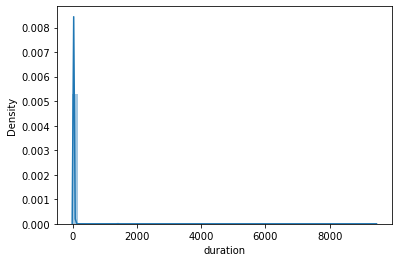

In [10]:
sns.distplot(df.duration)

In [11]:
df.duration.describe()

count    2.964624e+06
mean     1.561295e+01
std      3.485105e+01
min     -1.356667e+01
25%      7.150000e+00
50%      1.163333e+01
75%      1.868333e+01
max      9.455400e+03
Name: duration, dtype: float64

In [12]:
df["duration"].describe(percentiles= [.90, .98, .99])

count    2.964624e+06
mean     1.561295e+01
std      3.485105e+01
min     -1.356667e+01
50%      1.163333e+01
90%      2.886667e+01
98%      5.100000e+01
99%      6.045000e+01
max      9.455400e+03
Name: duration, dtype: float64

In [17]:
numerical = ['trip_distance']

In [36]:
train_data['PULocationID'].dtypes

dtype('O')

In [37]:
train_data['PU_DO']= train_data['PULocationID'] + '_' + train_data['DOLocationID']
val_data['PU_DO']= val_data['PULocationID']+ '_'+ val_data['DOLocationID']

In [38]:
categorical = ["PU_DO"] #['PULocationID', 'DOLocationID']  PU_DO works better as feature
#df[categorical] = df[categorical].astype(str)

In [39]:
train_dict= train_data[categorical + numerical].to_dict(orient ='records')

dv = DictVectorizer()
X_train = dv.fit_transform(train_dict)

target = 'duration'
Y_train = train_data[target].values

val_dict= val_data[categorical + numerical].to_dict(orient ='records')
X_val = dv.transform(val_dict)

Y_val = val_data[target].values


In [26]:
dv.feature_names_

['DOLocationID', 'PULocationID', 'trip_distance']

In [23]:
X_train.shape , X_val.shape

((73876, 3), (51489, 3))

In [40]:
Linear_re = LinearRegression()
Linear_re.fit(X_train, Y_train)

LinearRegression()

In [41]:
pred = Linear_re.predict(X_val)
mean_squared_error(Y_val, pred, squared=False)

6.173866891570694

/home/codespace/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/codespace/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


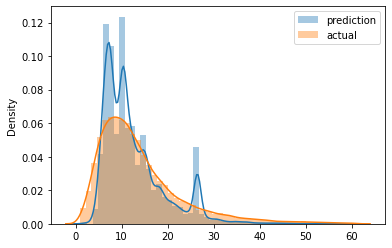

In [42]:
sns.distplot(pred, label ='prediction')
sns.distplot(Y_val, label ='actual')
plt.legend()

In [61]:
with open("../models/lin_reg.bin" ,'wb') as f_out:
    pickle.dump((dv,Linear_re), f_out)  # vectorization, lin_reg model

In [46]:
import os

os.getcwd()


'/workspaces/MLOps/01-intro'